# MRI Data Synthesizer Python Code - Gradient Sphere Phantom

### Importing libraries

In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
from mpl_toolkits.mplot3d import Axes3D
from scipy.interpolate import griddata

import concurrent.futures
import multiprocessing as mp
from numba import jit, prange # high performance python compiler
import time

import os
parent_dir = os.getcwd()

# universal values:
N = 128 # dimensions of 3D array
I = 1j # defining the imaginary unit 

### 3D sphere image generation

In [2]:
# generate 3D spherical data (replace with actual data later)
# initialize array
sphere_array = np.zeros((N, N, N))

# define the center and radius of the sphere
c = (N//2, N//2, N//2) # // floor division to obtain integers
r = min(N, N, N)//4

# create meshgrid for x, y, z dimensions
x, y, z = np.ogrid[:N, :N, :N]
distances = np.sqrt((x - c[0])**2 + (y - c[1])**2 + (z - c[2])**2)

# masking to set values for the sphere
sphere_array[distances <= r] = 1 - (distances[distances <= r] / r)
# the sphere contains a gradient, points closer to the center have higher values 

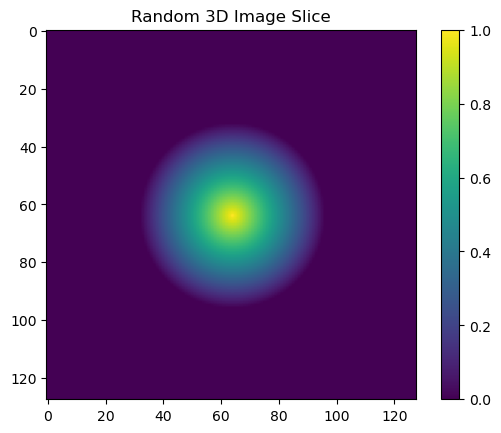

In [3]:
# display a slice of 3D array
slice_idx = N // 2 # central slice in the z direction (since N=28 for all dimensions)
plt.imshow(sphere_array[:,:,slice_idx]) 

plt.title('Random 3D Image Slice') # 14th slice 
plt.colorbar()
plt.show()

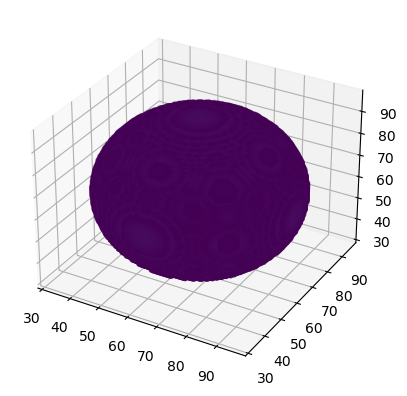

In [4]:
# 3D plot of sphere 
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# mesh grid of coordinates 
x,y,z = np.meshgrid(range(N), range(N), range(N))

# plot points with values greater than zero
mask = sphere_array > 0
ax.scatter(x[mask], y[mask], z[mask], c=sphere_array[mask])

plt.show()

In [5]:
# save spherical 3D image as .npy file 
#np.save('3D_sphere_gradient_array_128.npy', sphere_array)

### Load in data

In [6]:
# load in the array 
#sphere_array = np.load((os.path.join(parent_dir, '3D_sphere_gradient_array_128.npy')))

from scipy.io import loadmat
# go back a directory to load in trajectory
current_dir = os.getcwd()
if current_dir.endswith('DataSynthesizer'):
    os.chdir('..') 
traj = loadmat('traj/traj_gas_afia.mat')

# return to original directory
current_dir = os.getcwd()
if current_dir.endswith('Recon'):
    os.chdir(parent_dir)

# radial trajectory k-space x, y, and z points 
kx = traj['data'][:,:,0].ravel()
ky = traj['data'][:,:,1].ravel()
kz = traj['data'][:,:,2].ravel()

kx = kx*N
ky = ky*N
kz = kz*N

traj_list = np.column_stack((kx, ky, kz))

### Defining functions

In [7]:
def KSpaceScatterPlot(coordlist, s=5, title='3D Scatter Plot for K-Space Points'):
    '''Create a 3D scatter plot for k-space points
    
    Args: 
        kx - np.ndarray with shape (N, )
        ky - np.ndarray with shape (N, )
        kz - np.ndarray with shape (N, )
        s (scaling factor) - integer or float value (default value of 5)
        title - string of desired plot title (has default value)
    
    '''
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(coordlist[:,0], coordlist[:,1], coordlist[:,2], s=s)

    ax.set_xlabel('kx')
    ax.set_ylabel('ky')
    ax.set_zlabel('kz')
    ax.set_title(title)

    plt.show()

In [8]:
# OLD FUNCTION
#def CalculatePhasors(coordlist):
    
    # create an empty array to store phasors 
    #phasors = np.zeros_like(coordlist[:,0], dtype=complex)

    # calculate phasors for each data point 
    #for k in tqdm(range(coordlist.shape[0])):
        #phasors[k] = np.sum(sphere_array*np.exp(I*x*coordlist[k,0]*2*np.pi/N + I*y*coordlist[k,1]*2*np.pi/N + 
                                                #I*z*coordlist[k,2]*2*np.pi/N))
        
    #return phasors
# the faster function gives the exact same results when rounded up to 9 decimal places 

In [9]:
@jit(nopython=True, parallel=True)
def CalculatePhasors(coordlist, sphere_array):
    phasors_real = np.zeros(len(coordlist))
    phasors_imag = np.zeros(len(coordlist))
    
    # Counter to track progress
    #count = 0
    
    for i in prange(len(coordlist)):
        x_exp = x * coordlist[i, 0] * 2 * np.pi / N
        y_exp = y * coordlist[i, 1] * 2 * np.pi / N
        z_exp = z * coordlist[i, 2] * 2 * np.pi / N
        
        temp = np.sum(sphere_array * np.exp(I * x_exp + I * y_exp + I * z_exp))
        phasors_real[i] = temp.real
        phasors_imag[i] = temp.imag
        
        # Increment the count to track progress
        #count += 1
        
        # Print progress every 'n' iterations
        #if count % 1000 == 0:
            #print(f"Progress: {count}/{len(coordlist)} points")
    
    return phasors_real + 1j * phasors_imag

In [10]:
def PlotPhasors(coordlist, phasors, scale):
    # create arrows for phasors in 3D
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    # quiver plot to show phasors
    ax.quiver(coordlist[:,0], coordlist[:,1], coordlist[:,2], np.real(phasors)/30, np.imag(phasors)/30, 
                                                        np.zeros_like(phasors), color='red', length=scale)

    ax.set_xlabel('kx')
    ax.set_ylabel('ky')
    ax.set_zlabel('kz')
    ax.set_title('Arrows Representing Phasors in 3D')

    plt.show()

In [11]:
def Interp_MultiThread(data, traj, cast):
    # initializing lists 
    complex_phasors = [None] * len(cast) # preallocates memory by specifying length at this step

    Nblocks = 12  # set your desired number of blocks
    total_data_size = cast.shape[0]
    chunk_size = total_data_size // Nblocks  # calculate initial chunk size
    remainder = total_data_size % Nblocks  # calculate remainder for final block

    start = time.perf_counter()
    
    with concurrent.futures.ThreadPoolExecutor() as executor:
        futures = []
        index = 0
        
        for k in range(Nblocks):
            # adjust chunk size if remainder exists
            if remainder > 0:
                adjusted_chunk_size = chunk_size + 1
                remainder -= 1
            else:
                adjusted_chunk_size = chunk_size
            
            # calculating the indices for the current chunk
            end_index = index + adjusted_chunk_size
            if end_index > total_data_size:
                end_index = total_data_size
                
            # submitting the griddata function as a task to the executor
            future = executor.submit(griddata, traj, data, cast[index:end_index, :])
            futures.append((future, index, end_index))
            
            index = end_index
        
        # collecting results and assigning them to the correct positions in the final array
        for future, start_idx, end_idx in futures:
            result = future.result()
            complex_phasors[start_idx:end_idx] = result
    
    # convert list of interpolated phasors to numpy array
    complex_data = np.array(complex_phasors)
    
    print(f"Interpolated phasors calculated in {time.perf_counter()-start} seconds")
    
    return complex_data

In [12]:
@jit(nopython=True, fastmath=True) # speed up math with numba 
def BuildImageFAST(image, phasors, castlist):
    
    for k in range(phasors.shape[0]):
        if ~np.isnan(phasors[k]):
            image = image + phasors[k] * np.exp(-I*x*castlist[k,0]*2*np.pi/N - 
                                                I*y*castlist[k,1]*2*np.pi/N - 
                                                 I*z*castlist[k,2]*2*np.pi/N)
    return image

In [13]:
def BuildImage(phasors, castlist):
    # initialize array
    image = np.zeros_like(x, dtype=complex)
    
    # call fast function which uses numba
    image = BuildImageFAST(image, phasors, castlist)
    
    # rounding and rescaling by a factor of N^3 (to return to 0-1 scale)
    image = np.around(np.divide(image, N**3), decimals=10)
    
    return image

In [14]:
def DisplayImageSlice(image, slice_id=N//2, image_type='modulus'):
    
    # display real component
    if image_type == 'real' or  image_type == 'Real': 
        plt.imshow(np.real(image[:,:,slice_id])) # default is center slice 
        plt.title('Real Component of Image (2D Slice)') 
    # display imaginary component
    elif image_type == 'imag' or  image_type == 'Imag' or image_type == 'imaginary' or image_type == 'Imaginary':
        plt.imshow(np.imag(image[:,:,slice_id]))
        plt.title('Imaginary Component of Image (2D Slice)') # default is center slice 
    else: # display modulus (default)
        plt.imshow(np.abs(image[:,:,slice_id]))
        plt.title('Modulus Component of Image (2D Slice)') # default is center slice 

    plt.colorbar()
    plt.show()

In [15]:
def Interp2Rectilinear(kx, ky, kz, data, cast, method):
    start = time.perf_counter()
    traj = np.column_stack((kx.ravel(), ky.ravel(), kz.ravel())) # trajectory cooridnates 

    real = griddata(traj, data.real, cast, method=method)
    imag = griddata(traj, data.imag, cast, method=method)
    new_phasors = real + I*imag
    
    print(f"Interpolated phasors calculated in {time.perf_counter()-start} seconds")
    return new_phasors

### Generate perfect Cartesian k-space points, calculate "perfect" phasors, display real/imaginary images 

In [16]:
# creating 3D grids for x, y, and z dimensions
k_axis_vals = np.linspace(-N/2+1, N/2, N)
x, y, z = np.meshgrid(k_axis_vals, k_axis_vals, k_axis_vals)

# flatten 3D grids into 1D arrays
# ravel is faster than flatten, does not occupy memory
kx_0 = x.ravel()
ky_0 = y.ravel()
kz_0 = z.ravel()

cast_list = np.column_stack((kx_0, ky_0, kz_0)) # perfectly cartesian K-space coordinates
coord_list = cast_list

#### *Only run the following code at low N values for sanity checks*


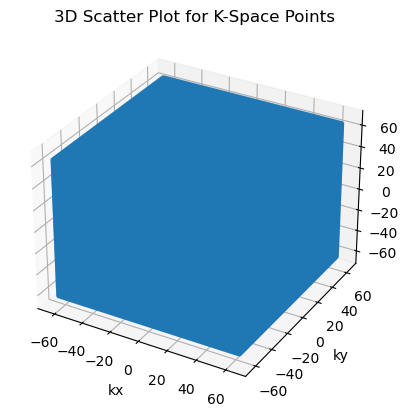

In [17]:
# plot k space coordinates
KSpaceScatterPlot(coord_list)

Phasors calculated in 5.611909141764045 seconds


/home/labast/miniconda3/envs/DukePipeline/lib/python3.8/site-packages/mpl_toolkits/mplot3d/axes3d.py:2615: ComplexWarning: Casting complex values to real discards the imaginary part
  UVW = np.column_stack(input_args[3:]).astype(float)


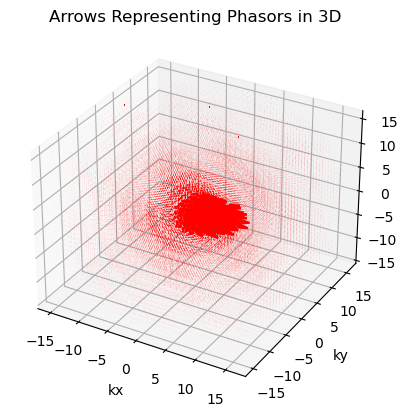

In [19]:
# calculate and plot phasors
# parallel computing
start = time.perf_counter()
perfect_phasors = CalculatePhasors(coord_list, sphere_array)
end = time.perf_counter()
print(f"Phasors calculated in {end-start} seconds")

PlotPhasors(coord_list, perfect_phasors, scale=0.5)

In [20]:
# save 3D phasor data as .npy file 
#np.save('3D_data_sphere_gradient_perfectphasors_128.npy', perfect_phasors)

Image built in 25.086342743597925 seconds


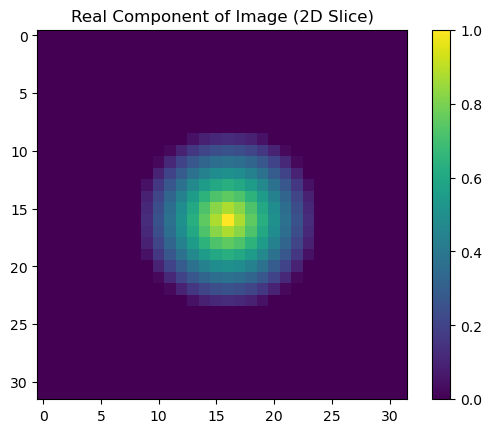

In [21]:
# inverse fourier transform to rebuild image 
start = time.perf_counter()
image = BuildImage(perfect_phasors, coord_list)
end = time.perf_counter()
print(f"Image built in {end-start} seconds")

# displaying real image slice
DisplayImageSlice(image, image_type='real') 

In [22]:
#np.save('3D_data_sphere_gradient_perfectimage_128.npy', image)

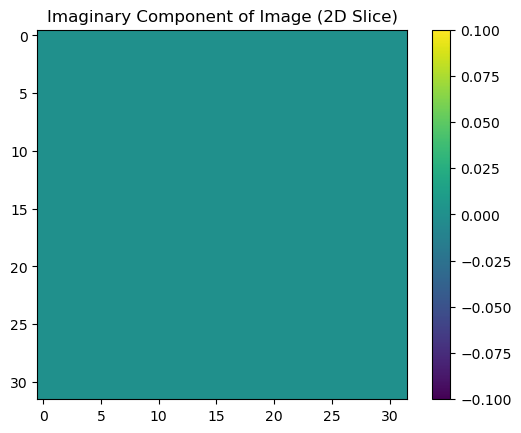

In [23]:
DisplayImageSlice(image, image_type='imag') 

In [24]:
# sanity check - should be the exact same as the original data (minus a few rounding discrepancies)
original = np.around(sphere_array, decimals=8) 
image_rounded = np.around(image, decimals=8)
np.array_equal(original, image_rounded)

True

In [25]:
# indices with rounding discrepancies 
#for i in range(0, image.shape[0]):
    #for j in range(0, image.shape[1]):
        #for k in range(0, image.shape[2]):
            #if image[i, j, k] != original[i, j, k]:
                #print(i, j ,k)

### For random, uniform points in k-space (requiring linear interpolation) 

In [17]:
def generate_random_points_inside_sphere(num_points, radius):
    points = []
    while len(points) < num_points:
        # Generate random points in a cube bounding the sphere
        x = np.random.uniform(-radius, radius)
        y = np.random.uniform(-radius, radius)
        z = np.random.uniform(-radius, radius)
        
        # Check if the point is inside the sphere
        if x**2 + y**2 + z**2 <= radius**2:
            points.append([x, y, z])
    
    return np.array(points)

num_points = 64000
radius = max(kx)  # Define your desired radius here

random_points = generate_random_points_inside_sphere(num_points, radius)

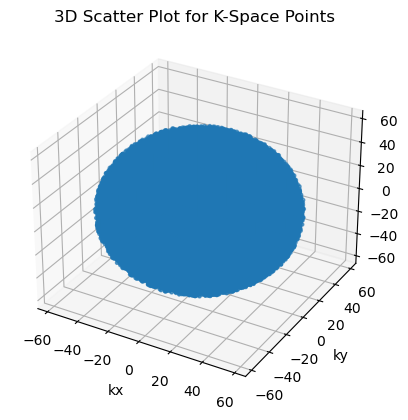

In [18]:
KSpaceScatterPlot(random_points)

In [19]:
# preparing Cartesian cast list
print(cast_list.shape)

# only keep points within trajectory 
# ex. no point in trying to cast to the corners with a radial trajectory
keep = (kx_0**2 + ky_0**2 + kz_0**2) < max(kx)**2
cast_list1 = cast_list[keep,:]
print(cast_list1.shape)

(2097152, 3)
(837817, 3)


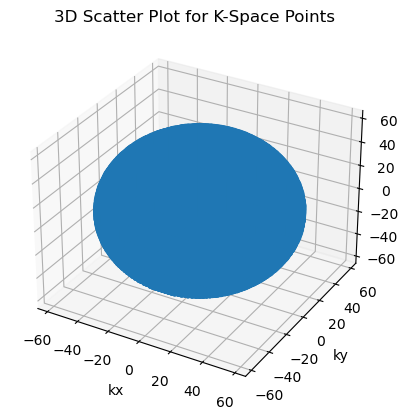

In [20]:
# plot k space coordinates
KSpaceScatterPlot(cast_list1)

Phasors calculated in 604.1032117749564 seconds


/home/labast/miniconda3/envs/DukePipeline/lib/python3.8/site-packages/mpl_toolkits/mplot3d/axes3d.py:2615: ComplexWarning: Casting complex values to real discards the imaginary part
  UVW = np.column_stack(input_args[3:]).astype(float)


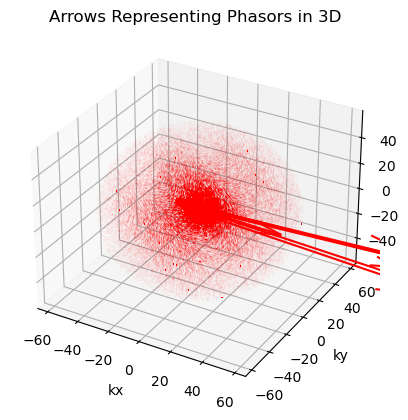

In [43]:
# calculate and plot phasors
# parallel computing
start = time.perf_counter()
phasors1 = CalculatePhasors(random_points, sphere_array)
end = time.perf_counter()
print(f"Phasors calculated in {end-start} seconds")

PlotPhasors(random_points, phasors1, scale=0.5) 

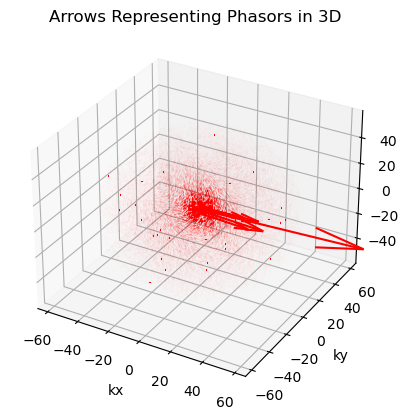

In [58]:
# different scaling 
PlotPhasors(random_points, phasors1, scale=0.1) 

In [53]:
# interpolating to Cartesian space
# using linear interpolation
new_phasors1 = Interp_MultiThread(phasors1, random_points, cast_list1)

Interpolated phasors calculated in 4.72051218803972 seconds


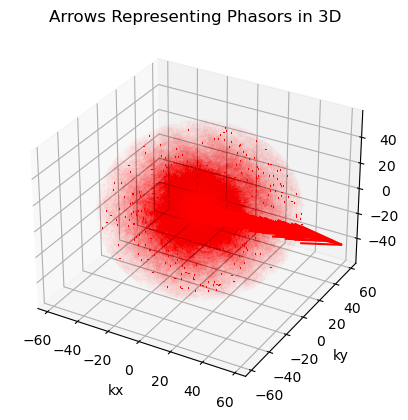

In [57]:
# plot new phasors
PlotPhasors(cast_list1, new_phasors1, scale=0.1)

In [60]:
# function altered for nearest interpolation method
new_phasors2 = Interp_MultiThread(phasors1, random_points, cast_list1)

Interpolated phasors calculated in 0.1842502737417817 seconds


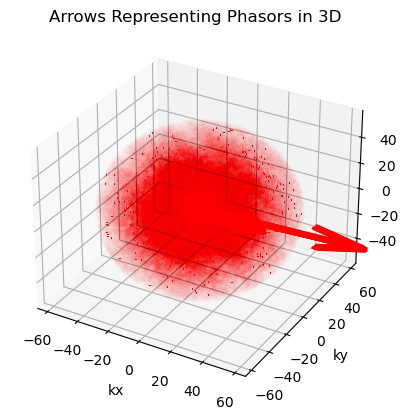

In [61]:
# plot new phasors
PlotPhasors(cast_list1, new_phasors2, scale=0.1)

In [67]:
def quadShift128(A):
    '''swaps the 8 corners of a 128x128x128 3D array (for later FFT)'''
    A = A[np.r_[64:128,0:64], :, :]
    A = A[:,np.r_[64:128,0:64], :]
    A = A[:,:,np.r_[64:128,0:64]]
    return A

def kspaceList_to_ImageArray(traj, data, N=128):
    '''turns Mx3 kSpace coords and M data into an NxNxN image'''
    F = np.zeros((N, N, N),dtype=np.complex_)
    for k in range(len(data)):
        F[int(round(traj[k, 0] + N / 2)), int(round(traj[k, 1] + N / 2)), int(round(traj[k, 2] + N / 2))] = data[k]
    F[~np.isfinite(F)] = 0
    print(F.shape)
    F = quadShift128(F)
    f = np.fft.ifftn(F)
    f = quadShift128(f)
    return f

In [68]:
new_image1 = kspaceList_to_ImageArray(cast_list1, new_phasors1)

(128, 128, 128)


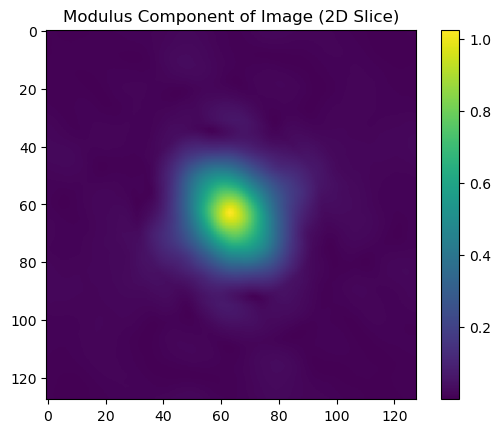

In [69]:
# linear interpolated image
# displaying modulus of center slice 
DisplayImageSlice(new_image1, image_type='modulus') 

In [73]:
#np.save('3D_data_sphere_gradient_post_linearinterpolation_image_128_thesis.npy', new_image1)

In [70]:
new_image2 = kspaceList_to_ImageArray(cast_list1, new_phasors2)

(128, 128, 128)


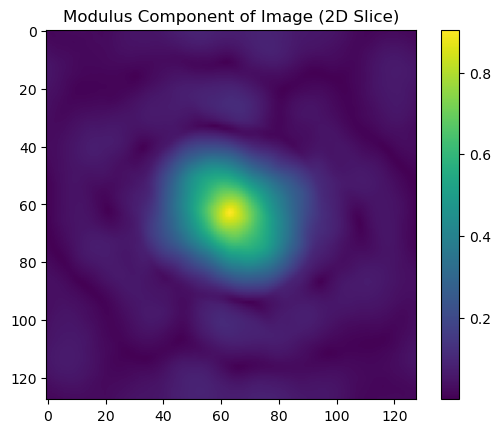

In [71]:
# nearest interpolated image 
# displaying modulus of center slice 
DisplayImageSlice(new_image2, image_type='modulus') 

In [74]:
#np.save('3D_data_sphere_gradient_post_nearestinterpolation_image_128_thesis.npy', new_image2)

### Linear interpolation using 3D kush ball (radial) k-space trajectory

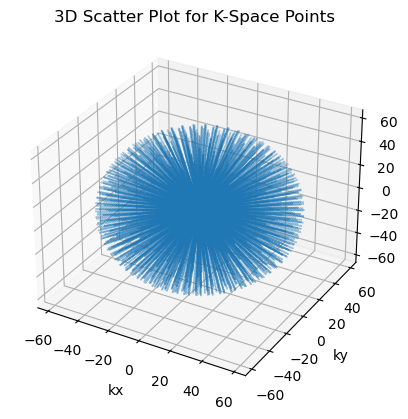

In [22]:
# create 3D scatter plot for kx, ky, kz trajectory points
# create 3D scatter plot
KSpaceScatterPlot(traj_list, s=0.1)

In [23]:
# calculate and plot phasors
# parallel computing
start = time.perf_counter()
phasors3 = CalculatePhasors(traj_list, sphere_array)
end = time.perf_counter()
print(f"Phasors calculated in {end-start} seconds")

Phasors calculated in 595.111001376 seconds


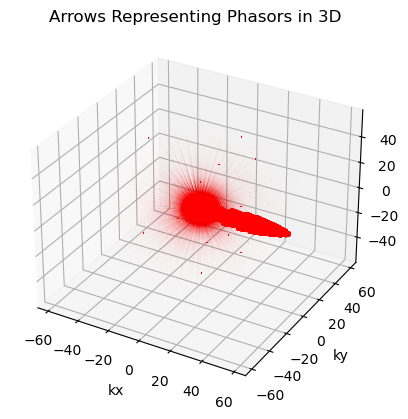

In [25]:
PlotPhasors(traj_list, phasors3, scale=0.05)

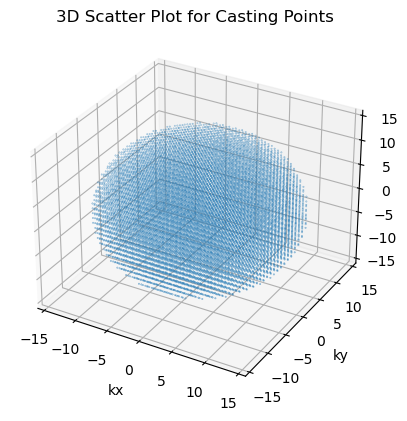

In [64]:
# create 3D scatter plot 
KSpaceScatterPlot(cast_list, s=0.1, title='3D Scatter Plot for Casting Points')

In [26]:
# preparing cast list
print(cast_list.shape)

# only keep points within trajectory 
# ex. no point in trying to cast to the corners with a radial trajectory
keep = (kx_0**2 + ky_0**2 + kz_0**2) < max(kx)**2
cast_list2 = cast_list[keep,:]
print(cast_list2.shape)

(2097152, 3)
(837817, 3)


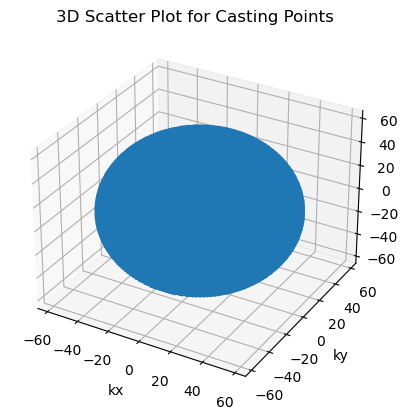

In [27]:
# create 3D scatter plot 
KSpaceScatterPlot(cast_list2, s=0.1, title='3D Scatter Plot for Casting Points')

In [28]:
# interpolating to Cartesian space 
new_phasors3 = Interp_MultiThread(phasors3, traj_list, cast_list2)

Interpolated phasors calculated in 263.101543042 seconds


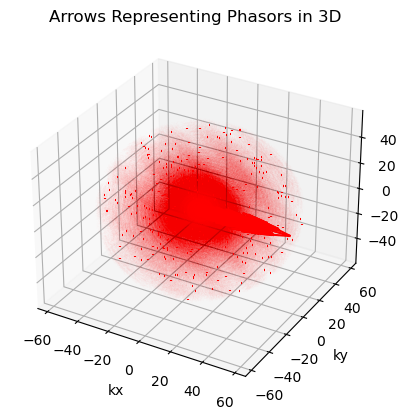

In [30]:
# plot post-interpolated phasors 
PlotPhasors(cast_list2, new_phasors3, scale=0.05)

In [32]:
# converting from k-space to image space 
new_image3 = kspaceList_to_ImageArray(cast_list2, new_phasors3)

(128, 128, 128)


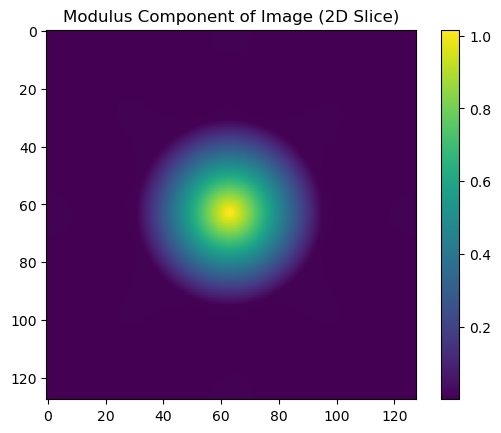

In [33]:
# displaying real image slice
DisplayImageSlice(new_image3, image_type='modulus') 

### Comparing perfect data to results obtained from linear interpolation with radial trajectory

/Users/mia/opt/anaconda3/envs/DukePipeline/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1340: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


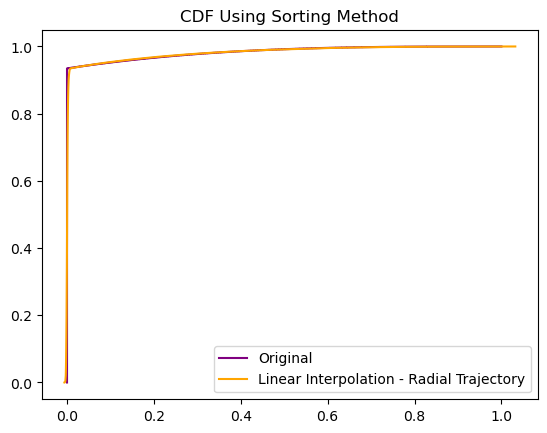

In [35]:
# Looking at Cumulative Distribution Function (CDF)  
x_0 = np.sort(sphere_array.ravel())
y_0 = np.arange(len(sphere_array.ravel())) / float(len(sphere_array.ravel()))

# Linear interpolation with radial trajectory
x_2 = np.sort(new_image3.ravel())
y_2 = np.arange(len(new_image3.ravel())) / float(len(new_image3.ravel()))

plt.title('CDF Using Sorting Method')

plt.plot(x_0, y_0, color='purple', label='Original')
plt.plot(x_2, y_2, color='orange', label='Linear Interpolation - Radial Trajectory')

plt.legend()

/Users/mia/opt/anaconda3/envs/DukePipeline/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1340: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


Text(0.5, 1.0, 'Boxplots')

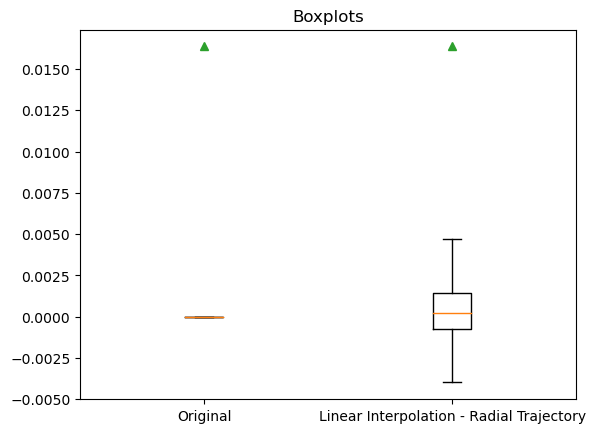

In [37]:
plt.boxplot([sphere_array.reshape(sphere_array.shape[0]**3),
             new_image3.reshape(new_image3.shape[0]**3)], showfliers=False, showmeans=True,
           labels=["Original", 'Linear Interpolation - Radial Trajectory'])
plt.title('Boxplots')

## Importing Binary Multisphere Phantom for Further Analyses...

In [21]:
# function to create a binary sphere in a 3D numpy array
def create_sphere(arr, center, radius):
    for x in range(arr.shape[0]):
        for y in range(arr.shape[1]):
            for z in range(arr.shape[2]):
                if (x - center[0])**2 + (y - center[1])**2 + (z - center[2])**2 <= radius**2:
                    arr[x, y, z] = 1

# function to check if a new sphere overlaps with existing spheres
def check_overlap(new_center, existing_centers, min_distance):
    for center in existing_centers:
        if np.linalg.norm(np.array(new_center) - np.array(center)) < min_distance:
            return True
    return False

# set seed for reproducible randomness
np.random.seed(203)

# create an NxNxNarray filled with zeros
phantom = np.zeros((N, N, N))

# define the number of spheres and create non-overlapping spheres in the phantom image
num_spheres = 6  # choose 5-6 spheres
sphere_centers = []
min_distance = 10  # minimum distance between sphere centers to avoid overlap

while len(sphere_centers) < num_spheres:
    center = np.random.randint(10, 118, size=3)  # random center coordinates within the image
    radius = np.random.randint(3, 40)  # random radius between 3 and 39
    
    if not check_overlap(center, sphere_centers, min_distance):
        create_sphere(phantom, center, radius)
        sphere_centers.append(center)

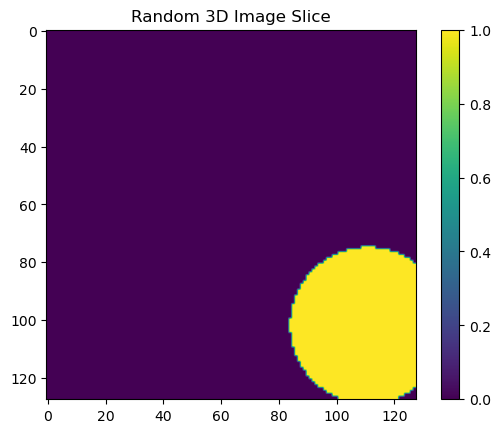

In [22]:
# display a slice of 3D array
slice_idx = N // 2 # central slice in the z direction (since N=128 for all dimensions)
plt.imshow(phantom[:,:,slice_idx]) 

plt.title('Random 3D Image Slice') # 14th slice 
plt.colorbar()
plt.show()

### Comparison of Linear Interpolation and Gridding Method

In [23]:
new_image1 = np.load('data/3D_binary_multisphere_radtraj_postinterpolated_image_128.npy')
new_image2 = np.load('data/3D_binary_multisphere_radtraj_image_128_postDukeRecon.npy')

In [24]:
new_image2 = np.abs(np.transpose(new_image2, (1, 2, 0)))[127::-1, 127::-1, 127::-1]

In [26]:
new_image1 = abs(new_image1)
new_image1 = (new_image1 - np.min(new_image1)) / (np.max(new_image1) - np.min(new_image1))
new_image2 = (new_image2 - np.min(new_image2)) / (np.max(new_image2) - np.min(new_image2))

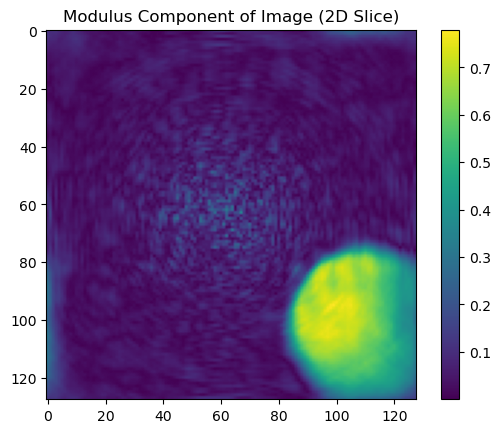

In [28]:
# linear interpolated image
DisplayImageSlice(new_image1, image_type='modulus') 

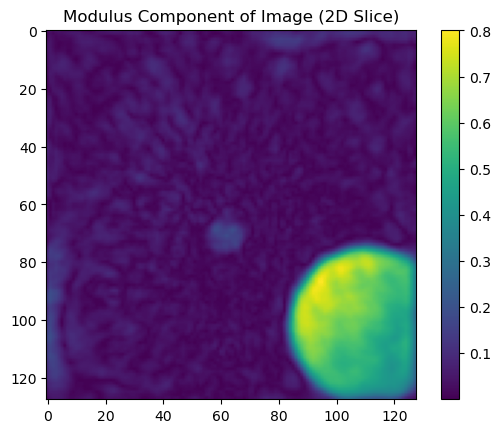

In [29]:
# gridding reconstructed image 
DisplayImageSlice(new_image2, image_type='modulus') 

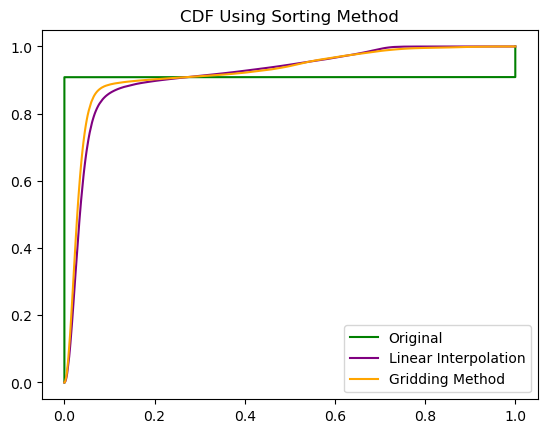

In [27]:
# Looking at Cumulative Distribution Function (CDF)
# Perfect data 
phantom = abs(phantom)
x_0 = np.sort(phantom.ravel())
y_0 = np.arange(len(phantom.ravel())) / float(len(phantom.ravel()))

# Linear interpolation 
new_image1 = abs(new_image1)
x_1 = np.sort(new_image1.ravel())
y_1 = np.arange(len(new_image1.ravel())) / float(len(new_image1.ravel()))

# Nearest interpolation 
new_image2 = abs(new_image2)
x_2 = np.sort(new_image2.ravel())
y_2 = np.arange(len(new_image2.ravel())) / float(len(new_image2.ravel()))

plt.title('CDF Using Sorting Method')

plt.plot(x_0, y_0, color='green', label='Original')
plt.plot(x_1, y_1, color='purple', label='Linear Interpolation')
plt.plot(x_2, y_2, color='orange', label='Gridding Method')

plt.legend()

In [30]:
import skimage.util

def makeSlidenew(A, slices):
    '''Displays selected image slices (z axis values) of a 3D array as a 2D grayscale image montage'''
    selected_slices = [abs(A[:,:,k]) for k in slices]
    plt.imshow(skimage.util.montage(selected_slices, padding_width=1, fill=0))
    plt.show()

# Usage example
slices_to_display = [25, 35, 45, 55, 65, 75, 85, 95, 105]

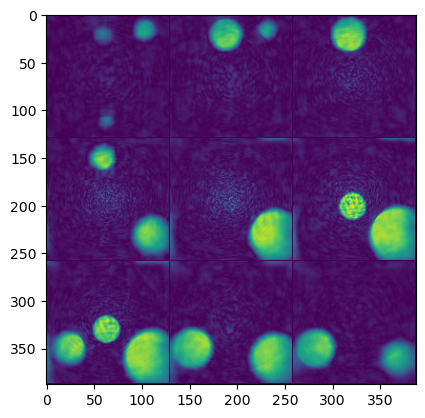

In [31]:
# linear interpolated slices
makeSlidenew(new_image1, slices_to_display)

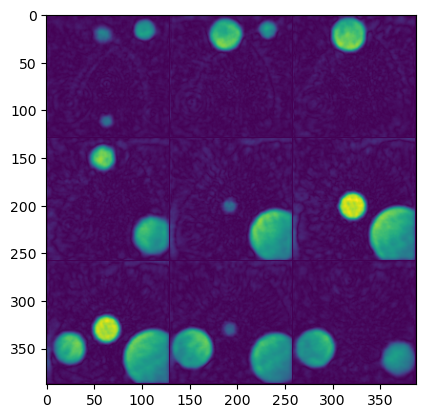

In [32]:
# gridding reconstructed slices 
makeSlidenew(new_image2, slices_to_display)

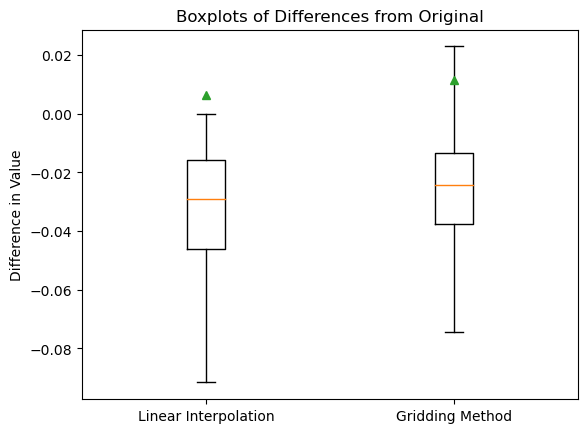

In [34]:
# boxplots as difference from original 
diff_image1 = phantom - new_image1
diff_image2 = phantom - new_image2

diff_image1_flat = diff_image1.reshape(-1)
diff_image2_flat = diff_image2.reshape(-1)

import matplotlib.pyplot as plt

plt.boxplot([diff_image1_flat, diff_image2_flat], 
            showfliers=False, 
            showmeans=True, 
            labels=['Linear Interpolation', 'Gridding Method'])
plt.title('Boxplots of Differences from Original')
plt.ylabel('Difference in Value')
plt.show()


### Comparing Undersampled Images

In [35]:
# loading in normal data
image128_DirectInterp_norm = np.load('data/3D_binary_multisphere_radtraj_postinterpolated_image_128.npy')
image128_DukeRecon_norm = np.load('data/3D_binary_multisphere_radtraj_image_128_postDukeRecon.npy')

image128_DukeRecon_norm = np.abs(np.transpose(image128_DukeRecon_norm, (1, 2, 0)))[127::-1, 127::-1, 127::-1]

image128_DirectInterp_norm = abs(image128_DirectInterp_norm)
image128_DirectInterp_norm = (image128_DirectInterp_norm - np.min(image128_DirectInterp_norm)) / (np.max(image128_DirectInterp_norm) - np.min(image128_DirectInterp_norm))
image128_DukeRecon_norm = (image128_DukeRecon_norm - np.min(image128_DukeRecon_norm)) / (np.max(image128_DukeRecon_norm) - np.min(image128_DukeRecon_norm))


In [36]:
# loading in undersampled data
image128_DukeRecon_undersamp32_norm = np.load('data/3D_binary_multisphere_radtraj_undersamp32000_image_128_postDukeRecon.npy')
image128_DirectInterp_undersamp32_norm = np.load('data/3D_binary_multisphere_radtraj_undersamp32000_postinterpolated_image_128.npy')
image128_DirectInterp_undersamp32_norm = abs(image128_DirectInterp_undersamp32_norm)

image128_DukeRecon_undersamp32_norm = (image128_DukeRecon_undersamp32_norm - np.min(image128_DukeRecon_undersamp32_norm)) / (np.max(image128_DukeRecon_undersamp32_norm) - np.min(image128_DukeRecon_undersamp32_norm))
image128_DirectInterp_undersamp32_norm = (image128_DirectInterp_undersamp32_norm - np.min(image128_DirectInterp_undersamp32_norm)) / (np.max(image128_DirectInterp_undersamp32_norm) - np.min(image128_DirectInterp_undersamp32_norm))


image128_DukeRecon_undersamp16_norm = np.load('data/3D_binary_multisphere_radtraj_undersamp16000_image_128_postDukeRecon.npy')
image128_DirectInterp_undersamp16_norm = np.load('data/3D_binary_multisphere_radtraj_undersamp16000_postinterpolated_image_128.npy')
image128_DirectInterp_undersamp16_norm = abs(image128_DirectInterp_undersamp16_norm)

image128_DukeRecon_undersamp16_norm = (image128_DukeRecon_undersamp16_norm - np.min(image128_DukeRecon_undersamp16_norm)) / (np.max(image128_DukeRecon_undersamp16_norm) - np.min(image128_DukeRecon_undersamp16_norm))
image128_DirectInterp_undersamp16_norm = (image128_DirectInterp_undersamp16_norm - np.min(image128_DirectInterp_undersamp16_norm)) / (np.max(image128_DirectInterp_undersamp16_norm) - np.min(image128_DirectInterp_undersamp16_norm))


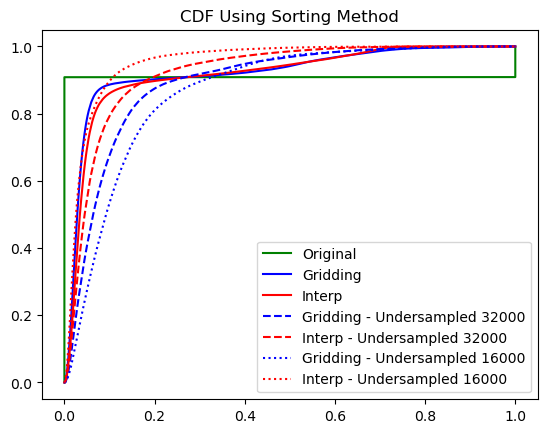

In [37]:
# Cumulative Distribution Function (CDF)  
# duke recon
x_0 = np.sort(image128_DukeRecon_norm.ravel())
y_0 = np.arange(len(image128_DukeRecon_norm.ravel())) / float(len(image128_DukeRecon_norm.ravel()))

# direct linear interpolation with radial trajectory
x_1 = np.sort(image128_DirectInterp_norm.ravel())
y_1 = np.arange(len(image128_DirectInterp_norm.ravel())) / float(len(image128_DirectInterp_norm.ravel()))

# original image
x_2 = np.sort(phantom.ravel())
y_2 = np.arange(len(phantom.ravel())) / float(len(phantom.ravel()))

# undersampled duke recon - 32000
x_3 = np.sort(image128_DukeRecon_undersamp32_norm.ravel())
y_3 = np.arange(len(image128_DukeRecon_undersamp32_norm.ravel())) / float(len(image128_DukeRecon_undersamp32_norm.ravel()))

# undersampled direct linear interpolation with radial trajectory - 32000
x_4 = np.sort(image128_DirectInterp_undersamp32_norm.ravel())
y_4 = np.arange(len(image128_DirectInterp_undersamp32_norm.ravel())) / float(len(image128_DirectInterp_undersamp32_norm.ravel()))

# undersampled duke recon - 16000
x_5 = np.sort(image128_DukeRecon_undersamp16_norm.ravel())
y_5 = np.arange(len(image128_DukeRecon_undersamp16_norm.ravel())) / float(len(image128_DukeRecon_undersamp16_norm.ravel()))

# undersampled direct linear interpolation with radial trajectory - 16000
x_6 = np.sort(image128_DirectInterp_undersamp16_norm.ravel())
y_6 = np.arange(len(image128_DirectInterp_undersamp16_norm.ravel())) / float(len(image128_DirectInterp_undersamp16_norm.ravel()))


plt.title('CDF Using Sorting Method')

plt.plot(x_2, y_2, color='green', label='Original')
plt.plot(x_0, y_0, color='blue', label="Gridding")
plt.plot(x_1, y_1, color='red', label='Interp')
plt.plot(x_3, y_3, linestyle='--', color='blue', label="Gridding - Undersampled 32000")
plt.plot(x_4, y_4, linestyle='--', color='red', label='Interp - Undersampled 32000')
plt.plot(x_5, y_5, linestyle=':', color='blue', label="Gridding - Undersampled 16000")
plt.plot(x_6, y_6, linestyle=':', color='red', label='Interp - Undersampled 16000')

plt.legend()